In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
from utils import quick_eda

df_train = pd.read_csv('../data/playground-series-s5e4/train.csv')
df_train['Episode_Index'] = df_train['Episode_Title'].str.extract(r'(\d+)').astype(int)
quick_eda(df_train)

Shape: 750000 rows and 13 columns
Duplicates check: 0 duplicate rows found

Sample data:


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Episode_Index
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,98
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,26
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,16
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,45
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,86


Data types and missing count:


,dtype,non_missing,missing,missing_pct
id,int64,750000,0,0.00
Podcast_Name,object,750000,0,0.00
Episode_Title,object,750000,0,0.00
Episode_Length_minutes,float64,662907,87093,11.61
Genre,object,750000,0,0.00
Host_Popularity_percentage,float64,750000,0,0.00
Publication_Day,object,750000,0,0.00
Publication_Time,object,750000,0,0.00
Guest_Popularity_percentage,float64,603970,146030,19.47
Number_of_Ads,float64,749999,1,0.00


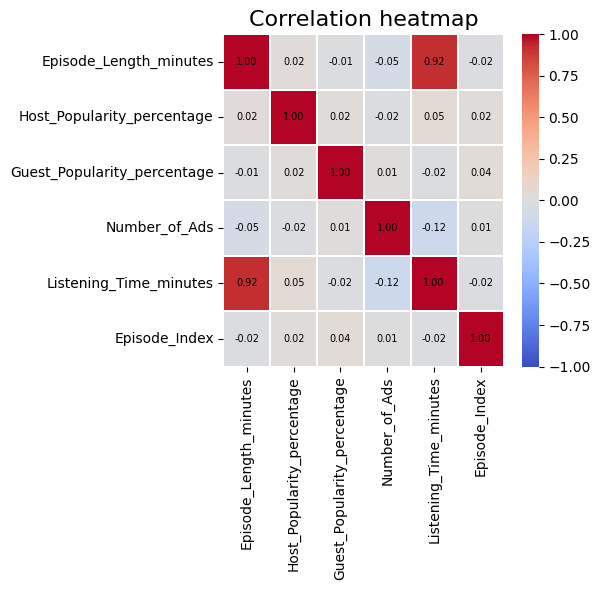

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_train.drop(columns='id').corr(numeric_only=True)

plt.figure(figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.01,
    annot=True,
    annot_kws={'fontsize':7, 'color': 'black'},
    fmt='.2f'
)

plt.title('Correlation heatmap', fontsize=16)
plt.tight_layout()
plt.show()

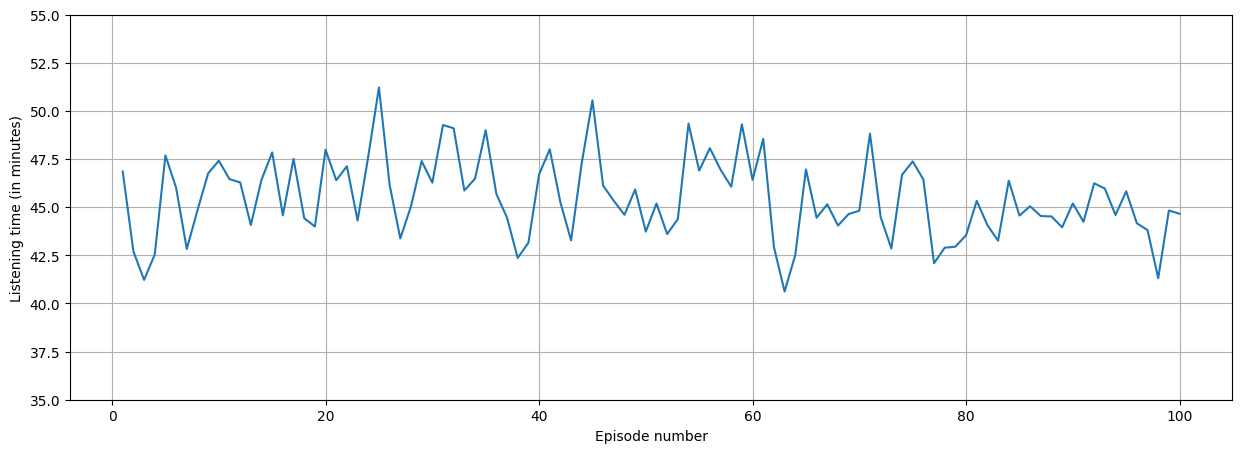

In [4]:
grouped_df = (
    df_train
    .groupby('Episode_Index', as_index=False)
    .agg({'Listening_Time_minutes': 'mean'})
)

plt.figure(figsize=(15, 5))
plt.plot(grouped_df['Episode_Index'], grouped_df['Listening_Time_minutes'])
plt.xlabel('Episode number')
plt.ylabel('Listening time (in minutes)')
plt.ylim(35, 55)
plt.grid()
plt.show()

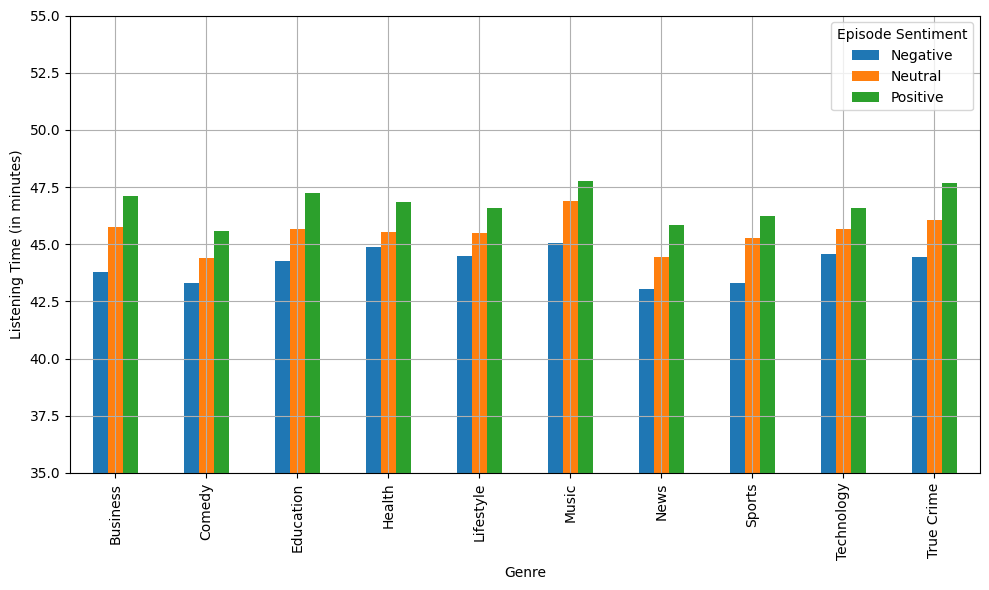

In [5]:
grouped_df = (
    df_train
    .groupby(['Genre', 'Episode_Sentiment'], as_index=False)
    .agg({'Listening_Time_minutes': 'mean'})
    .pivot(index='Genre', columns='Episode_Sentiment', values='Listening_Time_minutes')
)

fig, ax = plt.subplots(figsize=(10, 6))
grouped_df.plot(kind='bar', ax=ax)
ax.set_xlabel('Genre')
ax.set_ylabel('Listening Time (in minutes)')
ax.set_ylim(35, 55)
ax.grid()
ax.legend(title='Episode Sentiment')
plt.tight_layout()
plt.show()

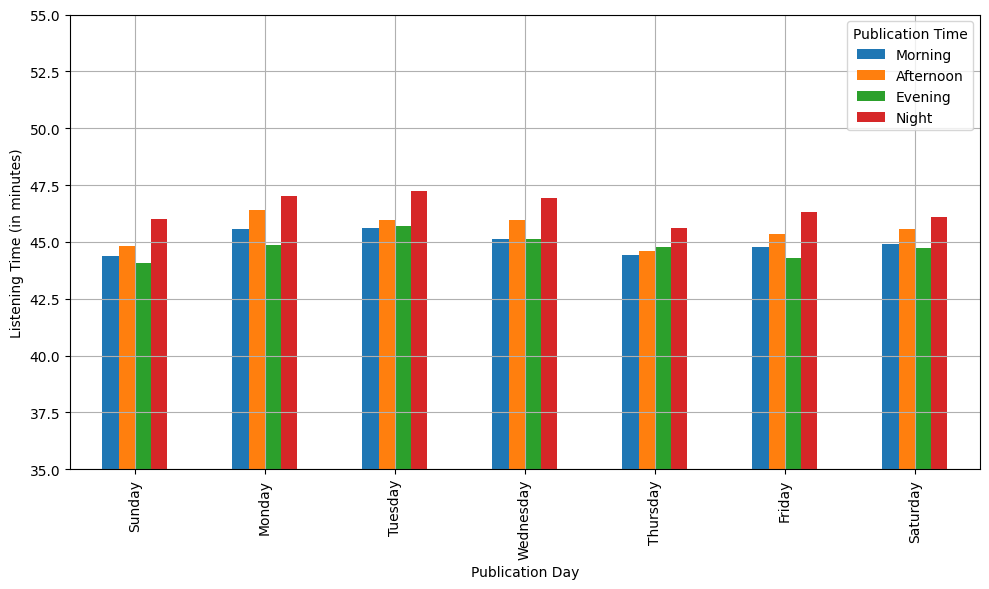

In [6]:
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

df_train['Publication_Day'] = pd.Categorical(df_train['Publication_Day'], categories=day_order, ordered=True)
df_train['Publication_Time'] = pd.Categorical(df_train['Publication_Time'], categories=time_order, ordered=True)

grouped_df = (
    df_train
    .groupby(['Publication_Day', 'Publication_Time'], as_index=False, observed=True)
    .agg({'Listening_Time_minutes': 'mean'})
    .pivot(index='Publication_Day', columns='Publication_Time', values='Listening_Time_minutes')
)

fig, ax = plt.subplots(figsize=(10, 6))
grouped_df.plot(kind='bar', ax=ax)
ax.set_xlabel('Publication Day')
ax.set_ylabel('Listening Time (in minutes)')
ax.set_ylim(35, 55)
ax.grid()
ax.legend(title='Publication Time')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

x = df_train.drop(columns=['id', 'Episode_Title', 'Episode_Index', 'Listening_Time_minutes'])
y = df_train['Listening_Time_minutes']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.35, random_state=42)

print(f'Treino: {x_train.shape}')
print(f'Validação: {x_valid.shape}')

Treino: (487500, 9)
Validação: (262500, 9)


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from scipy.stats import uniform, randint

class GroupImputer(OneToOneFeatureMixin, BaseEstimator, TransformerMixin):
    def __init__(self, group_col, impute_cols):
        self.group_col = group_col
        self.impute_cols = impute_cols
        self.group_means = None
        self.overall_means = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=[self.group_col] + self.impute_cols)
        self.group_means = X.groupby(self.group_col)[self.impute_cols].mean()
        self.overall_means = X[self.impute_cols].mean()
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=[self.group_col] + self.impute_cols)
        for col in self.impute_cols:
            X[col] = X[col].fillna(X[self.group_col].map(self.group_means[col]).fillna(self.overall_means[col]))
        return X[self.impute_cols]

preprocessor = ColumnTransformer(
    [
        (
            'target_encoding', 
            TargetEncoder(target_type='continuous'),
            ['Podcast_Name']
        ),
        (
            'onehot_encoding',
            OneHotEncoder(handle_unknown='ignore', sparse_output=False),
            ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
        ),
        (
            'missing_imputation',
            GroupImputer(group_col='Podcast_Name', impute_cols=['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']), 
            ['Podcast_Name', 'Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']
        )
    ],
    remainder='passthrough'
)


In [9]:
linear_regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_regression_pipeline.fit(x_train, y_train)

y_pred = linear_regression_pipeline.predict(x_valid)
score = root_mean_squared_error(y_valid, y_pred)

print(f'RMSE (validação): {score:.4f}')

RMSE (validação): 13.3669


In [10]:
df_test = pd.read_csv('../data/playground-series-s5e4/test.csv')
quick_eda(df_test)

Shape: 250000 rows and 11 columns
Duplicates check: 0 duplicate rows found

Sample data:


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


Data types and missing count:


,dtype,non_missing,missing,missing_pct
id,int64,250000,0,0.00
Podcast_Name,object,250000,0,0.00
Episode_Title,object,250000,0,0.00
Episode_Length_minutes,float64,221264,28736,11.49
Genre,object,250000,0,0.00
Host_Popularity_percentage,float64,250000,0,0.00
Publication_Day,object,250000,0,0.00
Publication_Time,object,250000,0,0.00
Guest_Popularity_percentage,float64,201168,48832,19.53
Number_of_Ads,float64,250000,0,0.00


In [11]:
test_results = linear_regression_pipeline.predict(df_test)
test_results

submission = pd.read_csv('../data/playground-series-s5e4/sample_submission.csv')
submission['Listening_Time_minutes'] = test_results
submission.to_csv('../outputs/playground-series-s5e4/submission.csv', index=False)
submission.head()

,id,Listening_Time_minutes
0,750000,55.691852
1,750001,19.821741
2,750002,51.494774
3,750003,81.571967
4,750004,49.830093
